In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter

sns.set(style="whitegrid")

In [2]:
#constants
MIN_WORD_LENGTH = 3
NGRAM_COUNT = 20
DATA_PATH =  "../Data/raw_analyst_ratings/raw_analyst_ratings.csv"

In [ ]:
def load_data(path):
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['date'] = df['date'].dt.tz_localize(None)
    return df

def configure_nltk():
    nltk_data_path = os.path.join(os.environ["USERPROFILE"], "AppData", "Roaming", "nltk_data")
    nltk.data.path.append(nltk_data_path)
    nltk.download('stopwords', download_dir=nltk_data_path)
    nltk.download('punkt', download_dir=nltk_data_path)
    
def preprocess_text(text, stop_words):
    text = re.sub(r'[^a-zA-Z ]', '', text)
    return ' '.join([word.lower() for word in text.split() if word.lower() not in stop_words])


# Visualizations

def plot_headline_length_distribution(df):
    df['headline_length'] = df['headline'].apply(len)
    sns.histplot(df['headline_length'], bins=50)
    plt.title('Distribution of Headline Lengths')
    plt.show()

def plot_top_publishers(df, top_n=10):
    top_publishers = df["publisher"].value_counts().head(top_n)
    top_publishers.plot(kind='barh', title='Top Publishers')
    plt.xlabel('Number of Articles')
    plt.ylabel('Publisher')
    plt.show()

def plot_articles_over_time(df):
    df['date_only'] = df['date'].dt.date
    articles_per_day = df.groupby('date_only').size()
    articles_per_day.plot(figsize=(15, 5), title='Articles Published Over Time')
    plt.ylabel('Number of Articles')
    plt.xlabel("Date")
    plt.show()

def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Cleaned Headlines')
    plt.show()

def plot_top_bigrams(df):
    def generate_bigrams(text):
        words = text.split()
        return [' '.join(pair) for pair in zip(words, words[1:])]

    bigrams = []
    df['clean_headline'].apply(lambda x: bigrams.extend(generate_bigrams(x)))
    bigram_counts = Counter(bigrams).most_common(NGRAM_COUNT)
    df_ngrams = pd.DataFrame(bigram_counts, columns=['Bigram', 'Frequency'])
    sns.barplot(data=df_ngrams, x='Frequency', y='Bigram')
    plt.title('Top 20 Bigrams in Headlines')
    plt.show()

def plot_time_distribution(df):
    df['publication_day'] = df['date'].dt.date
    df['publication_hour'] = df['date'].dt.hour
    df['publication_weekday'] = df['date'].dt.day_name()
    df['publication_month_year'] = df['date'].dt.to_period('M')

    sns.histplot(df['publication_hour'], bins=24)
    plt.title('Distribution of Article Publishing Times')
    plt.xlabel('Hour of Day (UTC-4)')
    plt.show()

    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    articles_by_weekday = df['publication_weekday'].value_counts().reindex(weekday_order)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=articles_by_weekday.index, y=articles_by_weekday.values, palette='magma')
    plt.title('Article Publication Frequency by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Number of Articles')
    plt.tight_layout()
    plt.show()

def plot_top_domains(df):
    df['publisher_domain'] = df['publisher'].str.extract(r'@([\w\.-]+)')
    top_domains = df['publisher_domain'].value_counts().head(10)
    top_domains.plot(kind='barh', title='Top Publisher Domains')
    plt.xlabel('Number of Articles')
    plt.show()

In [4]:
df = load_data(DATA_PATH)
df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59,A


### Descriptive statistics

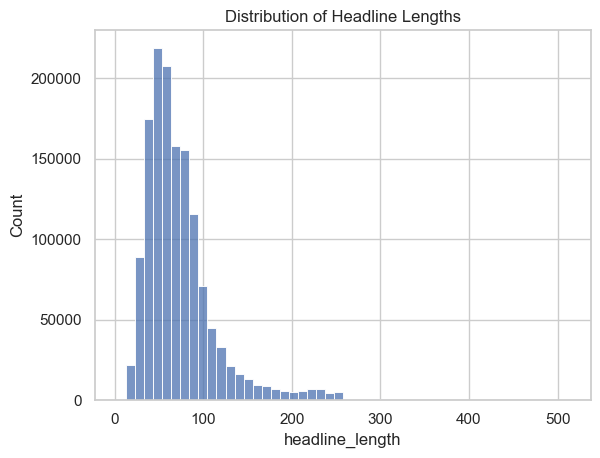

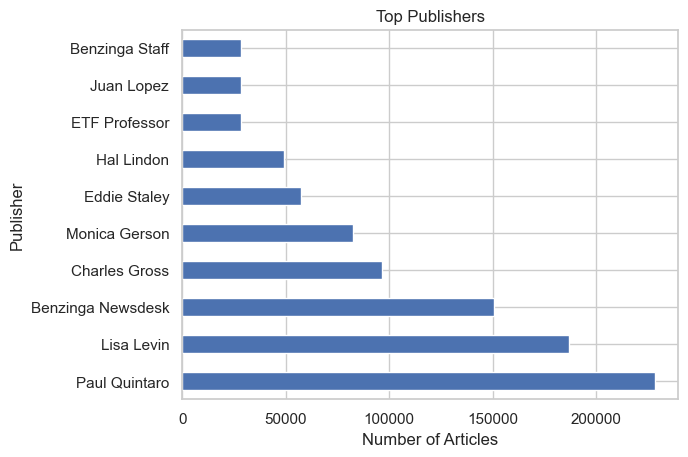

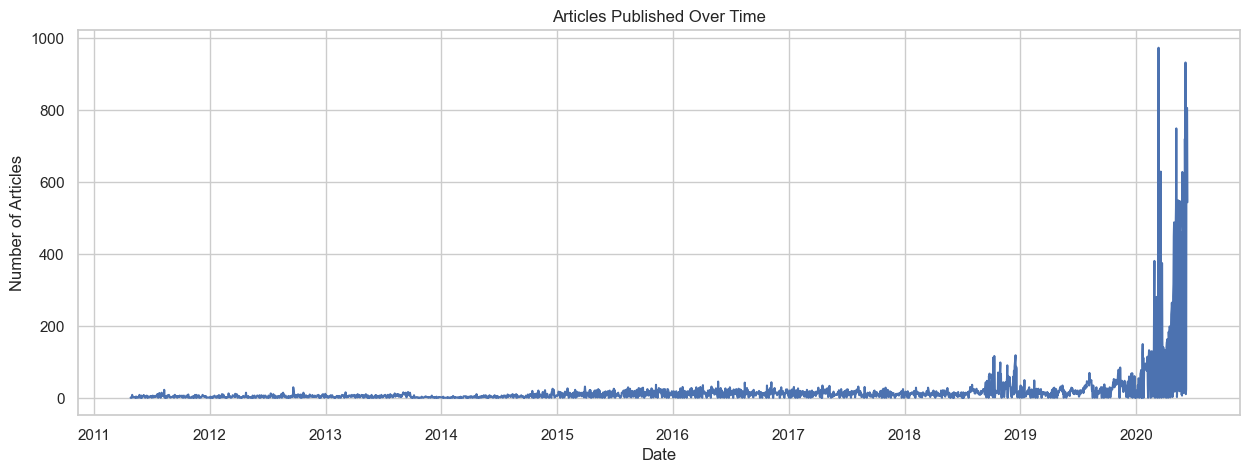

In [7]:
plot_headline_length_distribution(df)
plot_top_publishers(df)
plot_articles_over_time(df)

The graph shows that the number of articles about stock markets showed a massive spike in 2020, likely due to the COVID-19 pandemic and its impact on global economies. The number of articles has since stabilized but remains higher than pre-2020 levels.

### Text Analysis

In [5]:
configure_nltk()
stop_words = set(stopwords.words('english'))
df['clean_headline'] = df['headline'].apply(lambda x: preprocess_text(x, stop_words))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dagiM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dagiM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


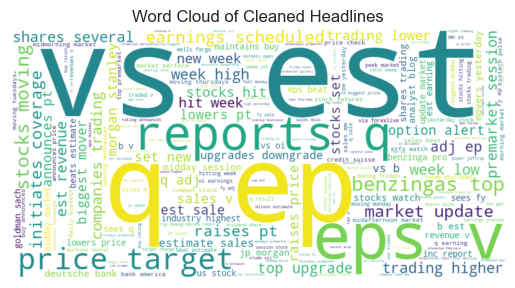

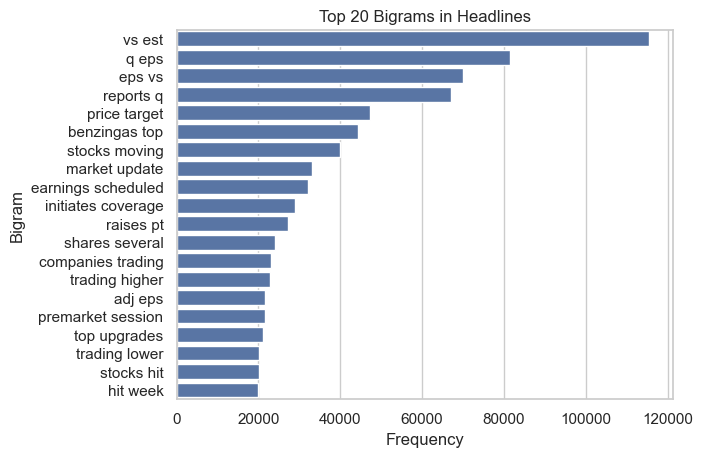

In [6]:
all_cleaned_text = ' '.join(df['clean_headline'])
generate_wordcloud(all_cleaned_text)
plot_top_bigrams(df)

From the analysis we can see phrases such as 'price target', 'stock moving', 'market update', 'initiates coverage', and 'earnings report' are frequently used in the context of stock market articles. This suggests that these articles often focus on financial performance, market predictions, and updates on stock movements.

### Time series analysis

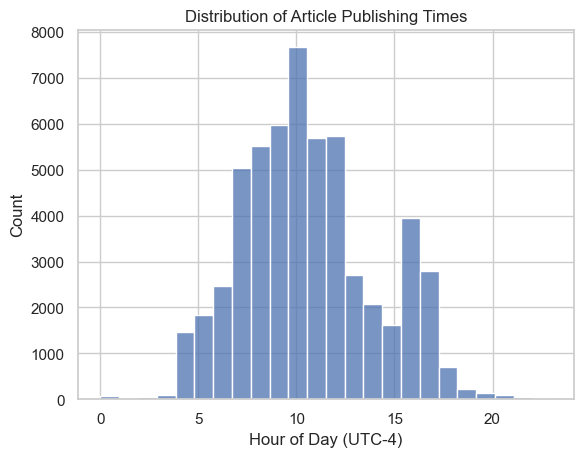

C:\Users\dagiM\AppData\Local\Temp\ipykernel_18208\2953630739.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=articles_by_weekday.index, y=articles_by_weekday.values, palette='magma')


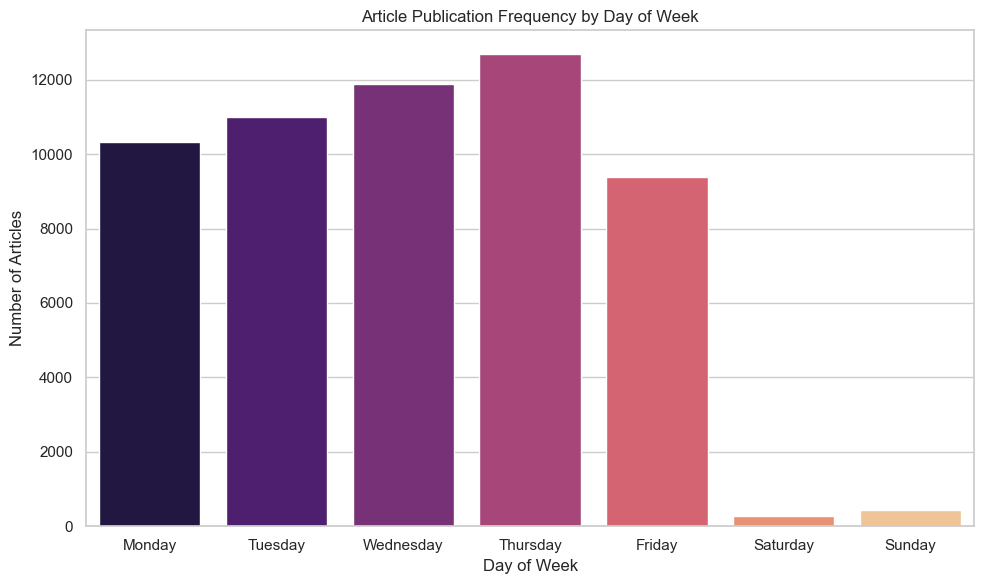

In [7]:
plot_time_distribution(df)

we can see that the workdays are more likely to have articles published than weekends, with a significant number of articles being published on Mondays and Fridays. This aligns with the typical business week where financial news is most relevant. Also, the mid day around 10:00 AM to 2:00 PM is the most active time for publishing articles, likely coinciding with market hours when stock movements are most relevant.

### Publisher Analysis

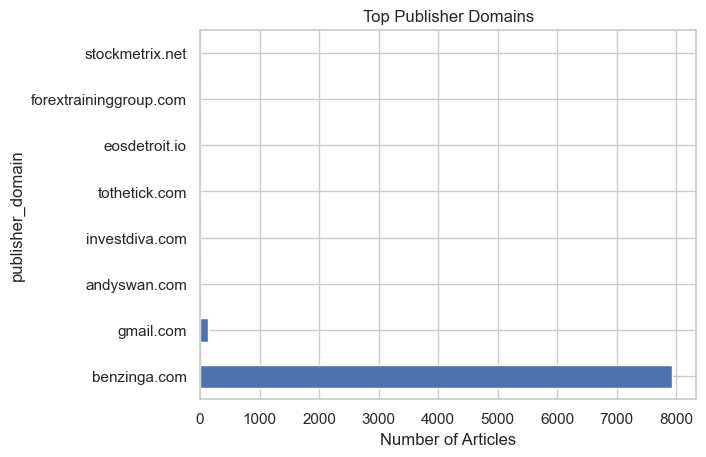

In [8]:
plot_top_domains(df)

Benzinga.com is the most used domain for stock market articles, followed by gmail.com. This suggests that these platforms are key sources of financial news and updates for readers interested in stock markets.